In [4]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

Improve the performance of gpt-40 through efficient prompt (trial and error prompt exploration)

In [5]:
# Load data
ground_truth = pd.read_csv("../../source_data/test_preprocess.csv")
predictions = {
    "SVM": pd.read_csv('../../evaluation/svm_predictions.csv'),
    "IndoBERT": pd.read_csv('../../evaluation/bert_predictions.csv'),
    # # zero-shot models
    # "GPT-3.5 Turbo Zero-Shot": pd.read_csv('../../evaluation/zero_shot_gpt-3.5-turbo_predictions.csv'),
    # "GPT-4 Turbo Zero-Shot": pd.read_csv('../../evaluation/zero_shot_gpt-4-turbo_predictions.csv'),
    # "GPT-4o Zero-Shot": pd.read_csv('../../evaluation/zero_shot_gpt-4o_predictions.csv'),
    # few-shot models
    # "GPT-3.5 Turbo Few-Shot": pd.read_csv('../../evaluation/few_shot_gpt-3.5-turbo_predictions.csv'),
    # "GPT-4 Turbo Few-Shot": pd.read_csv('../../evaluation/few_shot_gpt-4-turbo_predictions.csv'),
    "GPT-4o Few-Shot": pd.read_csv('few_shot_gpt-4o_predictions.csv'),
    "GPT-4o Few-Shot 1.1": pd.read_csv('few_shot_gpt-4o_predictions_rev.csv'),
    "GPT-4o Few-Shot 1.2": pd.read_csv('few_shot_gpt-4o_predictions_rev2.csv'),
    "GPT-4o Few-Shot 1.3": pd.read_csv('few_shot_gpt-4o_predictions_rev3.csv'),
    "GPT-4o Few-Shot 1.4": pd.read_csv('few_shot_gpt-4o_predictions_rev4.csv'),
    "GPT-4o Few-Shot 1.5": pd.read_csv('few_shot_gpt-4o_predictions_rev5.csv'),
    "GPT-4o Few-Shot 1.6": pd.read_csv('few_shot_gpt-4o_predictions_rev6.csv'),
}

# Configuration
aspect_keys = ["ac", "air_panas", "bau", "general", "kebersihan", 
               "linen", "service", "sunrise_meal", "tv", "wifi"]

In [6]:
df_rev = pd.read_csv('few_shot_gpt-4o_predictions_rev2.csv')
ground_truth = pd.read_csv("../../source_data/test_preprocess.csv")

# Ensure we're comparing the same rows (check indices or join on a common key if needed)
assert len(df_rev) == len(ground_truth), "Dataframes have different lengths!"

# Create comparison dataframe
comparison = pd.DataFrame({
    'review': ground_truth['review'],  # Assuming there's a text column
    'predicted_general': df_rev['linen'],
    'true_general': ground_truth['linen']
})

# Find mismatches
mismatches = comparison[comparison['predicted_general'] != comparison['true_general']]

# Print summary stats
# print(f"Total mismatches: {len(mismatches)}/{len(comparison)} ({len(mismatches)/len(comparison):.1%})")
# print("\nMismatch distribution:")
# print(mismatches['true_general'].value_counts())

# Display all mismatched rows with differences highlighted
def highlight_diff(row):
    if row['predicted_general'] != row['true_general']:
        return ['background-color: yellow']*3
    return ['']*3

mismatches

,review,predicted_general,true_general
18,Perlengkapan mandinya lengkap dan ac nya dingi...,neut,pos
35,kamar besar.. air hangat ada fasilitasnya tapi...,neut,neg
54,"toilet kurabg bersih,tempat sampah kotor,perle...",neut,neg
57,awalnya sudah merasa tidak nyaman karena lanta...,neut,neg
68,"wifi tidak sampai kamar, tidak tersedia heater...",neut,neg
79,1. Dalam kamar ada bbrp nyamuk. 2. Gantungan d...,neut,neg
85,"bersih, nyaman. cuma bantal kecil nya bau.",neut,neg
89,AC tidak dingin sama sekali sampai saya akhirn...,neg,neut
91,1. Tempat sampah penuh sampah dan tidak dibers...,neut,neg
106,"Kamarnya bersih, aminities lengkap, petugas ra...",neut,pos


In [7]:
def evaluate_model(true_df, pred_df, model_name):
    """Core evaluation function for a single model"""
    merged = true_df.merge(pred_df, on="review", suffixes=('_true', '_pred'))
    results = []
    
    for aspect in aspect_keys:
        y_true = merged[f"{aspect}_true"]
        y_pred = merged[f"{aspect}_pred"]
        
        report = classification_report(y_true, y_pred, 
                                      target_names=['neg', 'pos', 'neut'],
                                      output_dict=True)
        
        results.append({
            'model': model_name,
            'aspect': aspect,
            'accuracy': accuracy_score(y_true, y_pred),
            'macro_precision': report['macro avg']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'neg_precision': report['neg']['precision'],
            'neg_recall': report['neg']['recall'],
            'neg_f1': report['neg']['f1-score'],
            'pos_precision': report['pos']['precision'],
            'pos_recall': report['pos']['recall'],
            'pos_f1': report['pos']['f1-score'],
            'neut_precision': report['neut']['precision'],
            'neut_recall': report['neut']['recall'],
            'neut_f1': report['neut']['f1-score'],
            'support': report['weighted avg']['support']
        })
    
    return pd.DataFrame(results)

# Main evaluation pipeline
all_results = []
for model_name, pred_df in predictions.items():
    print(f"Evaluating {model_name}...")
    model_results = evaluate_model(ground_truth, pred_df, model_name)
    all_results.append(model_results)

# Generate key outputs
full_results = pd.concat(all_results, ignore_index=True)

Evaluating SVM...
Evaluating IndoBERT...
Evaluating GPT-4o Few-Shot...
Evaluating GPT-4o Few-Shot 1.1...
Evaluating GPT-4o Few-Shot 1.2...
Evaluating GPT-4o Few-Shot 1.3...
Evaluating GPT-4o Few-Shot 1.4...
Evaluating GPT-4o Few-Shot 1.5...
Evaluating GPT-4o Few-Shot 1.6...


In [10]:
# 1. Model Comparison Table
model_comparison = full_results.groupby('model').agg({
    'accuracy': 'mean',
    'macro_precision': 'mean',
    'macro_recall': 'mean',
    'macro_f1': 'mean',
    'weighted_precision': 'mean',
    'weighted_recall': 'mean',
    'weighted_f1': 'mean',
    'neg_precision': 'mean',
    'neg_recall': 'mean',
    'neg_f1': 'mean',
    'pos_precision': 'mean',
    'pos_recall': 'mean',
    'pos_f1': 'mean',
    'neut_precision': 'mean',
    'neut_recall': 'mean',
    'neut_f1': 'mean',
    'support': 'mean'
}).reset_index()

print("\n=== AVG Model Comparison ===")
model_comparison.round(4)


=== AVG Model Comparison ===


,model,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,neg_precision,neg_recall,neg_f1,pos_precision,pos_recall,pos_f1,neut_precision,neut_recall,neut_f1,support
0,GPT-4o Few-Shot,0.9455,0.8424,0.8603,0.8391,0.9513,0.9455,0.9455,0.8549,0.8148,0.8220,0.9625,0.9703,0.9654,0.7099,0.7959,0.7299,286.0
1,GPT-4o Few-Shot 1.1,0.9444,0.8477,0.8549,0.8381,0.9479,0.9444,0.9437,0.8418,0.8138,0.8106,0.9560,0.9756,0.9651,0.7453,0.7754,0.7385,286.0
2,GPT-4o Few-Shot 1.2,0.9462,0.8489,0.8683,0.8429,0.9521,0.9462,0.9467,0.8410,0.8414,0.8163,0.9606,0.9730,0.9660,0.7450,0.7907,0.7463,286.0
3,GPT-4o Few-Shot 1.3,0.9500,0.8568,0.8547,0.8473,0.9513,0.9500,0.9485,0.8788,0.7899,0.8254,0.9573,0.9803,0.9681,0.7344,0.7938,0.7482,286.0
4,GPT-4o Few-Shot 1.4,0.9594,0.8635,0.8629,0.8559,0.9601,0.9594,0.9583,0.9107,0.8058,0.8482,0.9653,0.9859,0.9751,0.7145,0.7971,0.7443,286.0
5,GPT-4o Few-Shot 1.5,0.9605,0.8712,0.8663,0.8610,0.9609,0.9605,0.9596,0.9081,0.8087,0.8493,0.9670,0.9845,0.9754,0.7384,0.8056,0.7585,286.0
6,GPT-4o Few-Shot 1.6,0.9612,0.8714,0.8685,0.8621,0.9620,0.9612,0.9603,0.9085,0.8098,0.8499,0.9679,0.9848,0.9760,0.7378,0.8109,0.7603,286.0
7,IndoBERT,0.9608,0.8129,0.8093,0.8060,0.9595,0.9608,0.9595,0.8238,0.8362,0.8269,0.9787,0.9761,0.9774,0.6363,0.6155,0.6136,286.0
8,SVM,0.9350,0.7000,0.6718,0.6724,0.9293,0.9350,0.9305,0.7453,0.7450,0.7435,0.9583,0.9741,0.9660,0.3962,0.2965,0.3077,286.0


# Viz

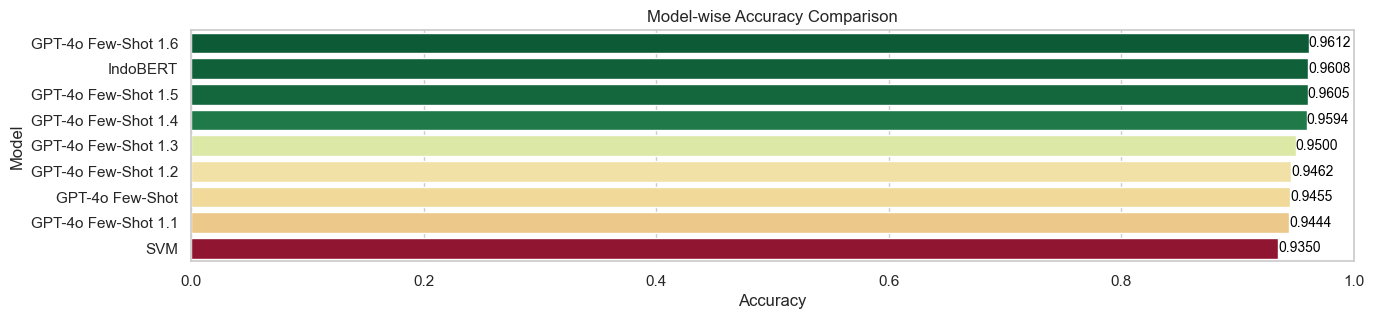

In [11]:
# 1. Model-wise Accuracy Comparison
sns.set_theme(style="whitegrid")
model_comparison = model_comparison.sort_values("accuracy", ascending=False)
norm = plt.Normalize(model_comparison["accuracy"].min(), model_comparison["accuracy"].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
colors = [sm.to_rgba(val) for val in model_comparison["accuracy"]]
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(data=model_comparison, x="accuracy", y="model", palette=colors, ax=ax)

# Annotate bars with accuracy values
for p in ax.patches:
    ax.annotate(f"{p.get_width():.4f}",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

ax.set_xlabel("Accuracy")
ax.set_ylabel("Model")
ax.set_title("Model-wise Accuracy Comparison")
ax.set_xlim(0, 1)
plt.show()

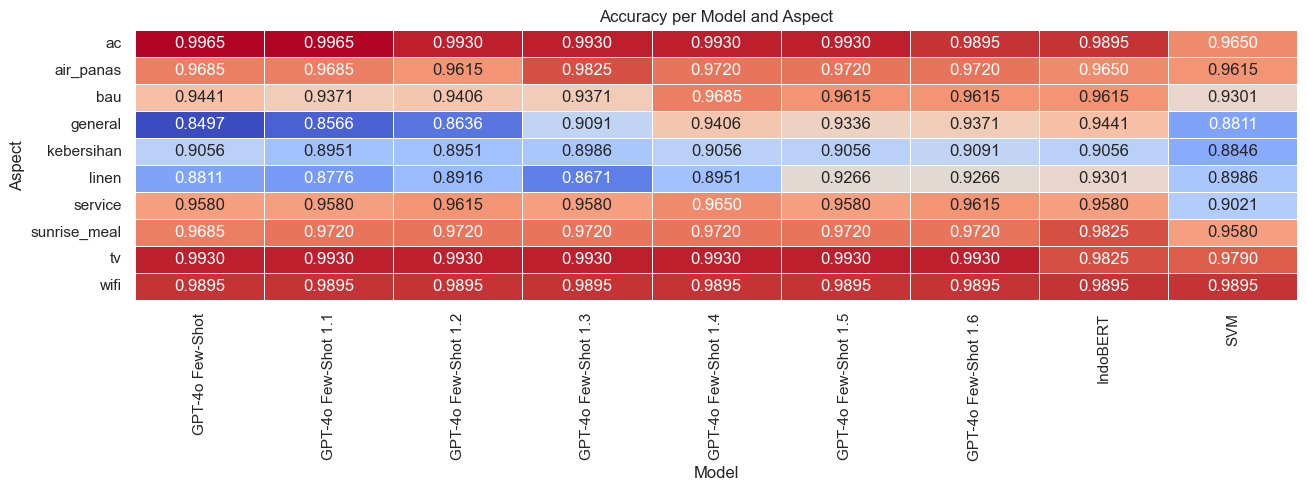

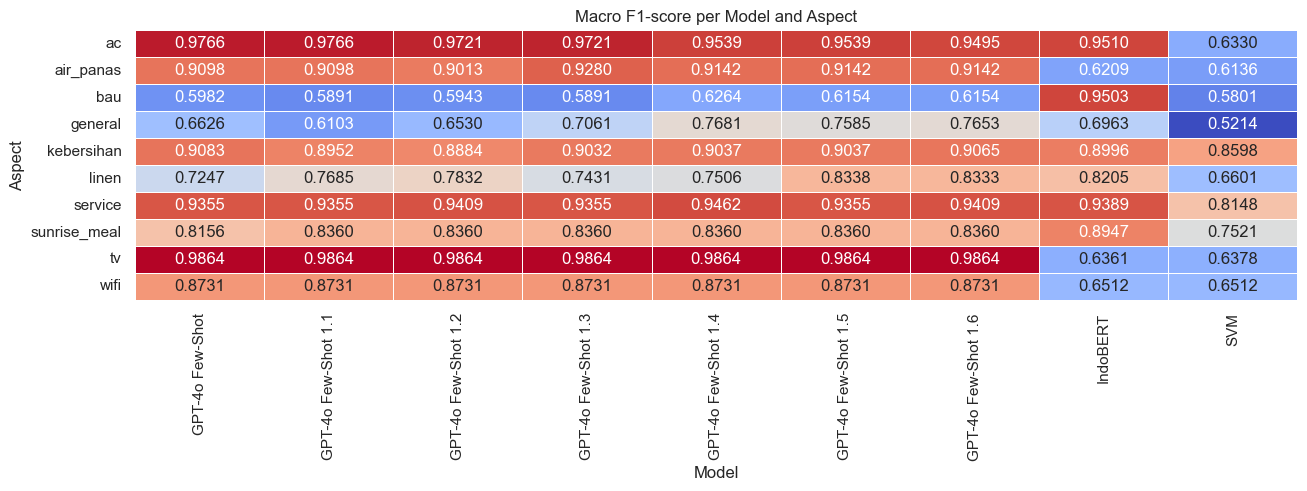

In [12]:
# 2. Heatmap for Macro Accuracy & F1-score per Model and Aspect
plt.figure(figsize=(15, 3.5))
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="accuracy", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, cbar=False)
plt.title("Accuracy per Model and Aspect")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()

plt.figure(figsize=(15, 3.5))
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="macro_f1", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5, cbar=False)
plt.title("Macro F1-score per Model and Aspect")
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.show()

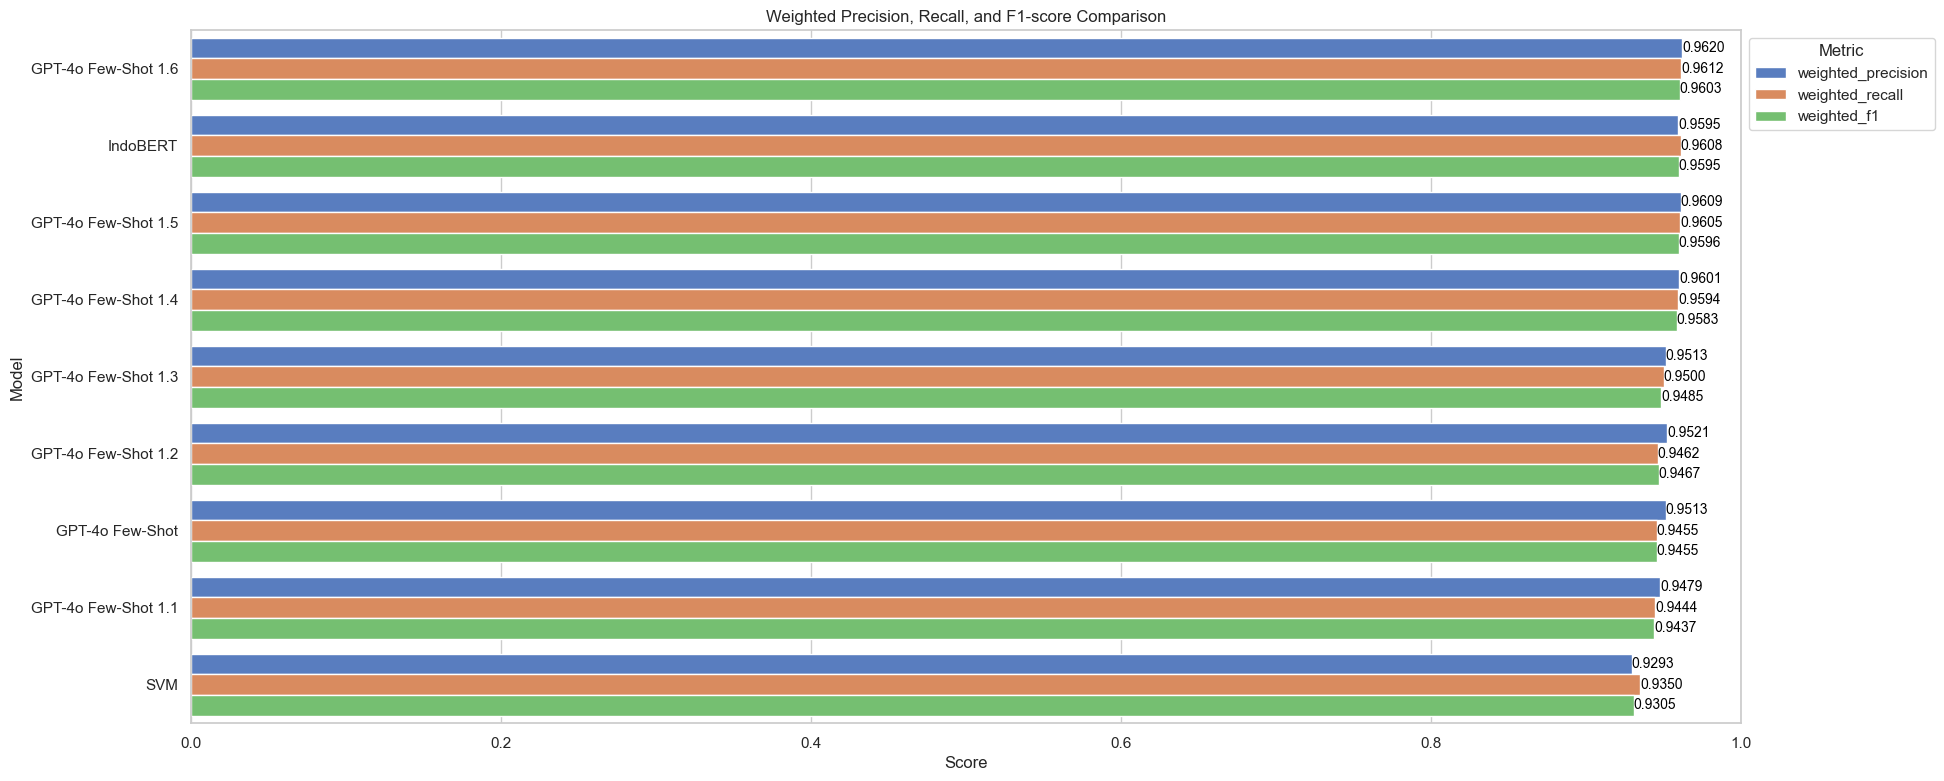

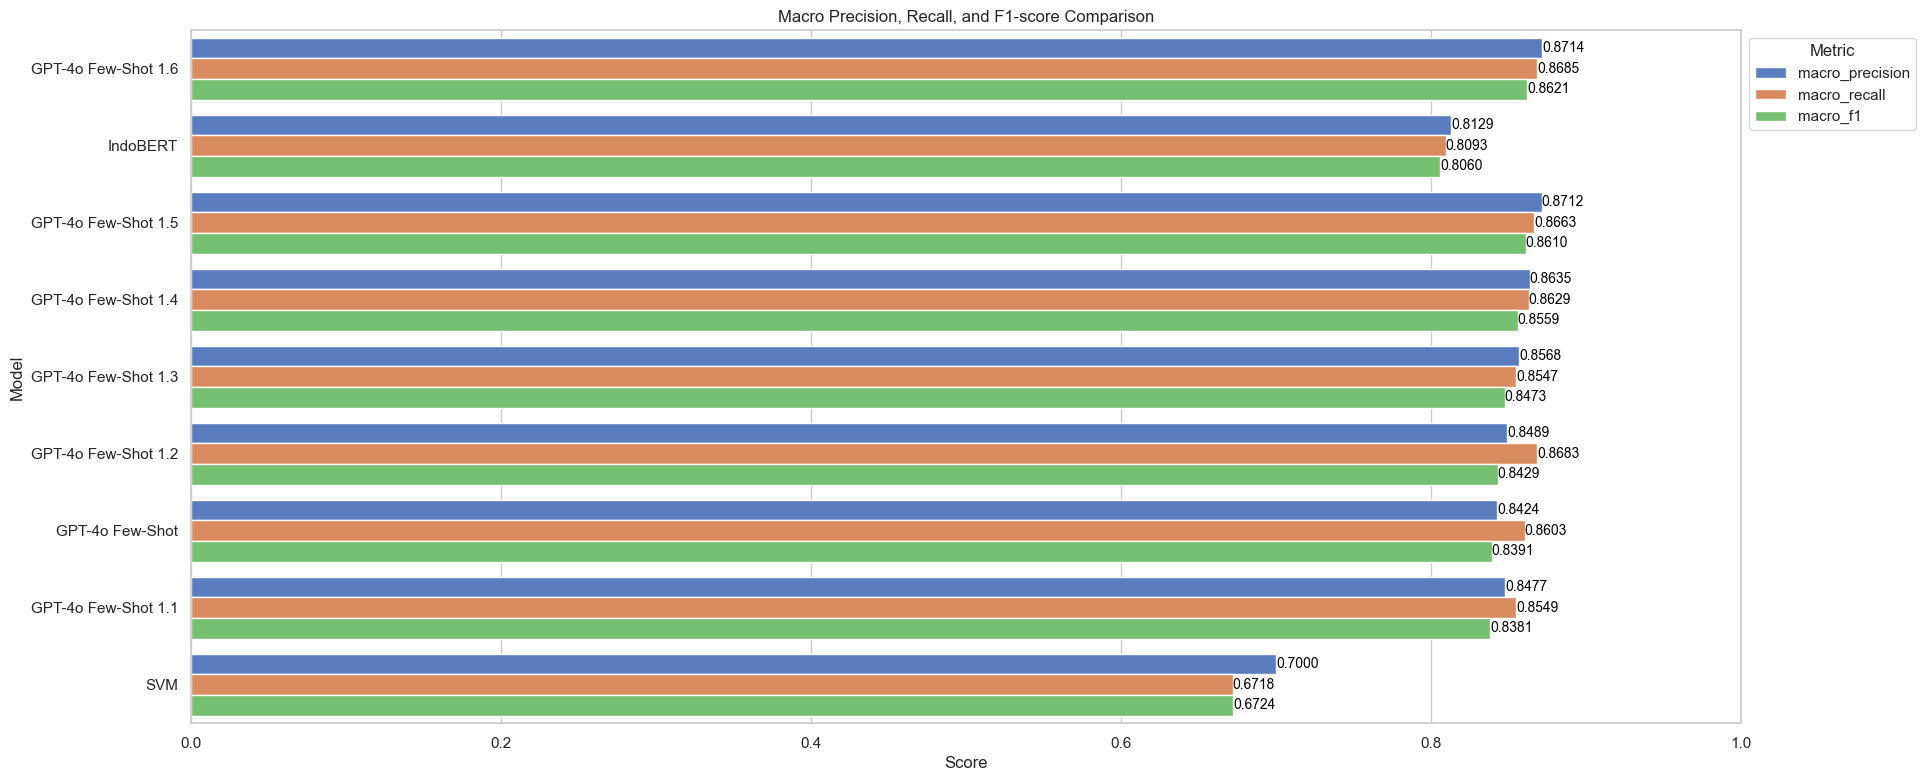

In [13]:
def add_value_labels(ax, decimal_places=4):
    """Adds value labels to bars in a barplot, skipping zeros."""
    for p in ax.patches:
        if p.get_width() > 0: 
            ax.annotate(f'{p.get_width():.{decimal_places}f}',
                        (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='left', va='center', fontsize=10, color='black')

# First plot: Weighted metrics
metrics = ["weighted_precision", "weighted_recall", "weighted_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")
plt.figure(figsize=(20, 9))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Weighted Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# Second plot: Macro metrics
metrics = ["macro_precision", "macro_recall", "macro_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")
plt.figure(figsize=(20, 9))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Macro Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

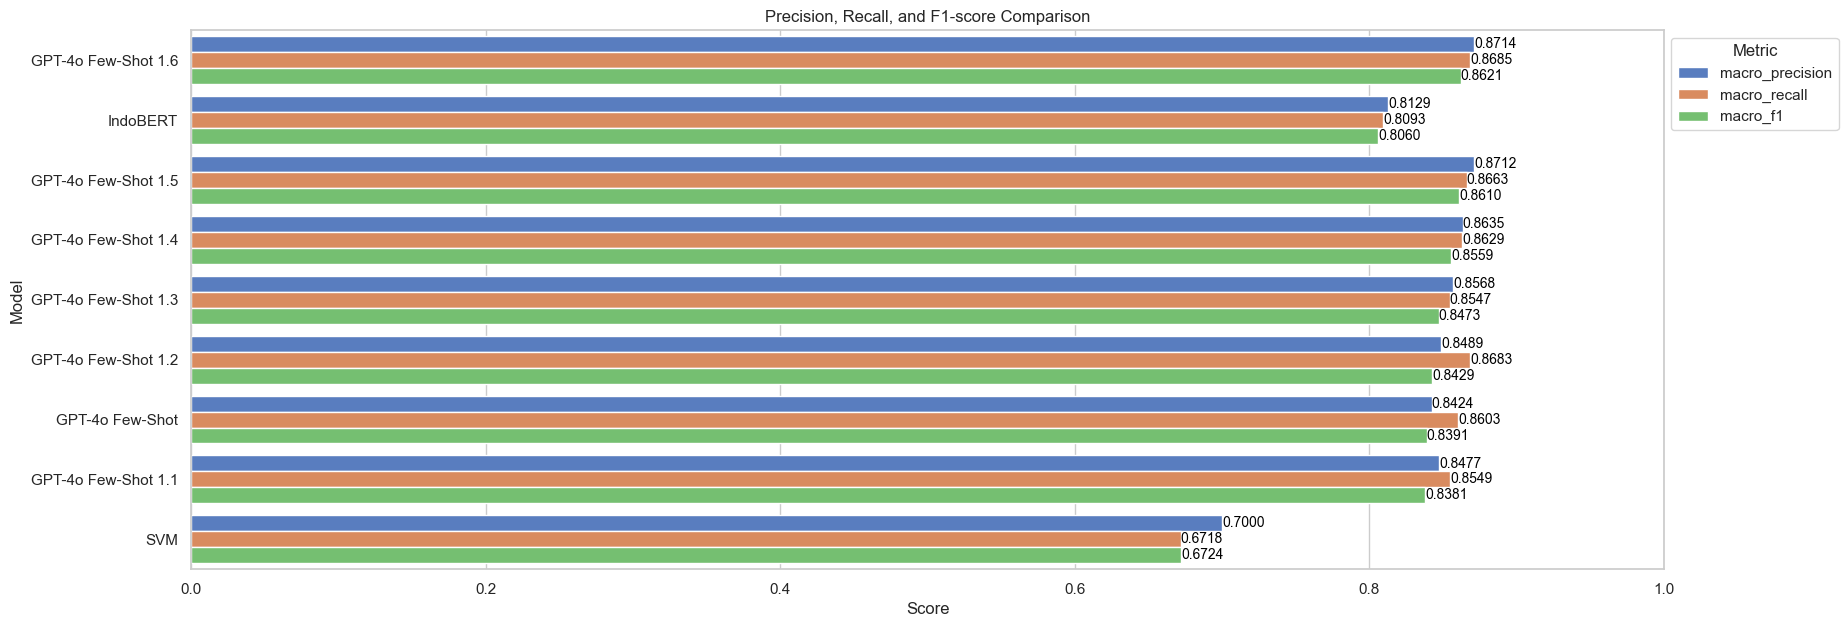

In [14]:
# Second plot: Macro metrics
metrics = ["macro_precision", "macro_recall", "macro_f1"]
melted_df = model_comparison.melt(id_vars=["model"], value_vars=metrics, var_name="Metric", value_name="Score")

plt.figure(figsize=(19, 7))
ax = sns.barplot(data=melted_df, x="Score", y="model", hue="Metric", palette="muted")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.title("Precision, Recall, and F1-score Comparison")
add_value_labels(ax)
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


In [113]:
melted_df

,model,Metric,Score
0,IndoBERT,macro_precision,0.812938
1,GPT-4o Few-Shot,macro_precision,0.842442
2,SVM,macro_precision,0.699951
3,GPT-4 Turbo Few-Shot,macro_precision,0.841351
4,GPT-4 Turbo Zero-Shot,macro_precision,0.827555
5,GPT-3.5 Turbo Few-Shot,macro_precision,0.814313
6,GPT-3.5 Turbo Zero-Shot,macro_precision,0.795476
7,GPT-4o Zero-Shot,macro_precision,0.791624
8,IndoBERT,macro_recall,0.809283
9,GPT-4o Few-Shot,macro_recall,0.860294


In [114]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # Display the DataFrame
# display(aspect_performance)

# # Reset to default after displaying
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')